(263, 330, 30)


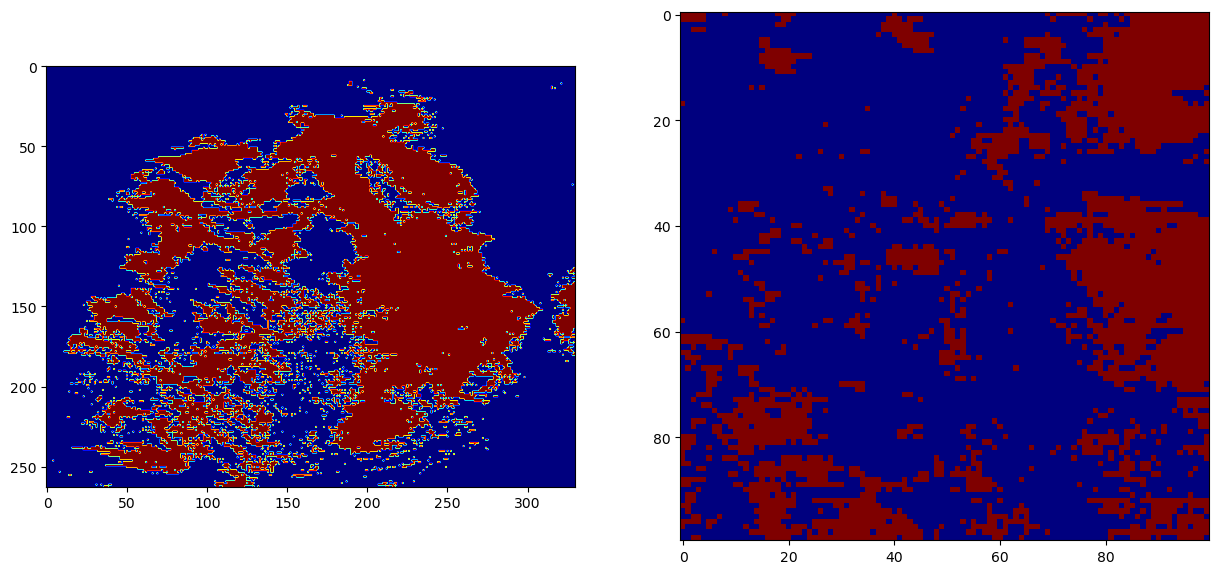

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
# import scipy.fft as spfft

# import bitis

path = Path("/Users/arstanbek/Projects/fibrosis/BiTis/data/3D")
slab = np.load(path.joinpath("slab.npy")).astype(np.float32)

slab[slab == 2] = -1
slab[slab == 0] = 1

slab = slab[::, 200:530:1, :]

print(slab.shape)

template = slab[100:200, 100:200, :10].copy()
template[template == 2] = -1

fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
axs[0].imshow(slab[:, :, slab.shape[2]//2], cmap="jet_r")
axs[1].imshow(template[:, :, template.shape[2]//2], cmap="jet_r")
plt.show()



1. Template size for each axis.
2. Split into several sections.
3. Use tensorflow?
4. Build 3D slab, slice by slice using NxMx2 template.
4.1. Generate central slice using the 2D version;
4.2. Use new template builder which takes into account previous slice pixels in the same indexes.

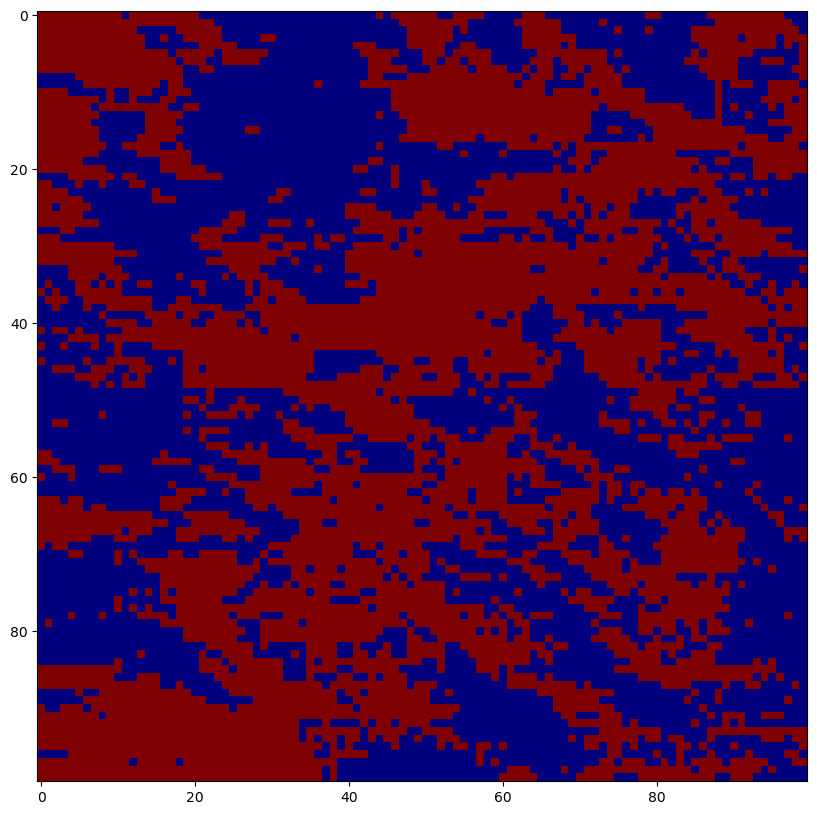

In [63]:
i_min = 150
i_max = 250
j_min = 50
j_max = 150
k_min = 15
k_max = 18

plt.figure(figsize=(15, 10))
plt.imshow(slab[i_min:i_max, j_min:j_max, k_min:k_min+1], cmap="jet_r")
plt.show()

In [64]:
import bitis as bt

print(slab.shape)

texture = slab[i_min:i_max, j_min:j_max, k_min:k_max].copy()
texture_ = texture.copy()
texture_[texture_ == -1] = 2

# texture = pyramid[2][:, :, pyramid[2].shape[2]//2].copy()

# texture_ = np.zeros(2 * np.array(texture.shape))

# for i in range(1, 3):
#     for j in range(1, 3):
#         i_min = (i - 1) * texture.shape[0]
#         i_max = i * texture.shape[0]
#         j_min = (j - 1) * texture.shape[1]
#         j_max = j * texture.shape[1]
#         texture_[i_min:i_max, j_min:j_max] = texture


# print(pyramid[2].shape, texture_.shape)
# texture_[texture_ > 0] = 2
# texture_[texture_ != 2] = 1

simulation_tex = np.zeros(texture_.shape)
# mask = np.random.random(texture_.shape) < 0.1
# simulation_tex[mask] = texture_[mask]
simulation = bt.AdaptiveSampling(simulation_tex,
                                 texture_,
                                 max_known_pixels=90,
                                 max_template_size=100,
                                 min_template_size=5,
                                 min_distance=0.0)

simulated_tex = simulation.run()

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(texture_[:, :,], vmin=0, vmax=2, cmap='jet')
# ax[1].imshow(simulated_tex, vmin=0, vmax=2, cmap='jet')
# plt.show()

(263, 330, 30)


100%|██████████| 30000/30000 [01:00<00:00, 493.25it/s]


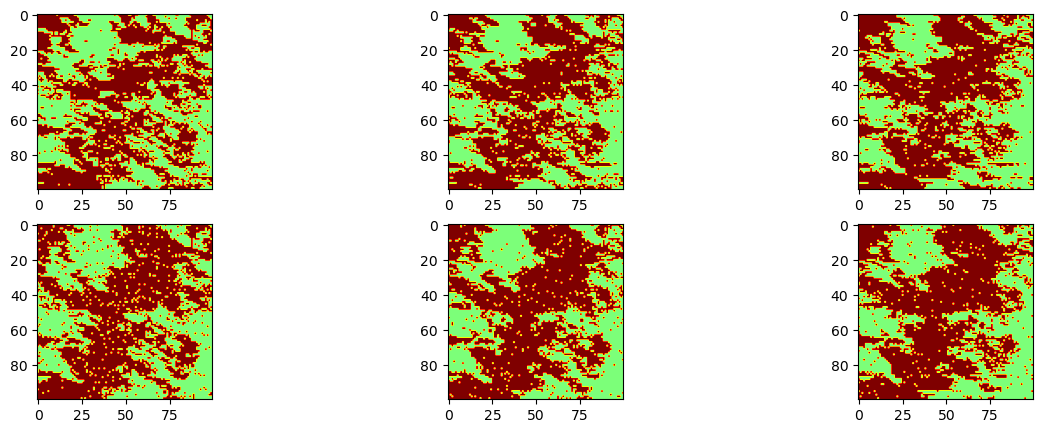

In [65]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(3):
    axs[0, i].imshow(texture_[..., i], vmin=0, vmax=2, cmap='jet')
    axs[1, i].imshow(simulated_tex[..., i], vmin=0, vmax=2, cmap='jet')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


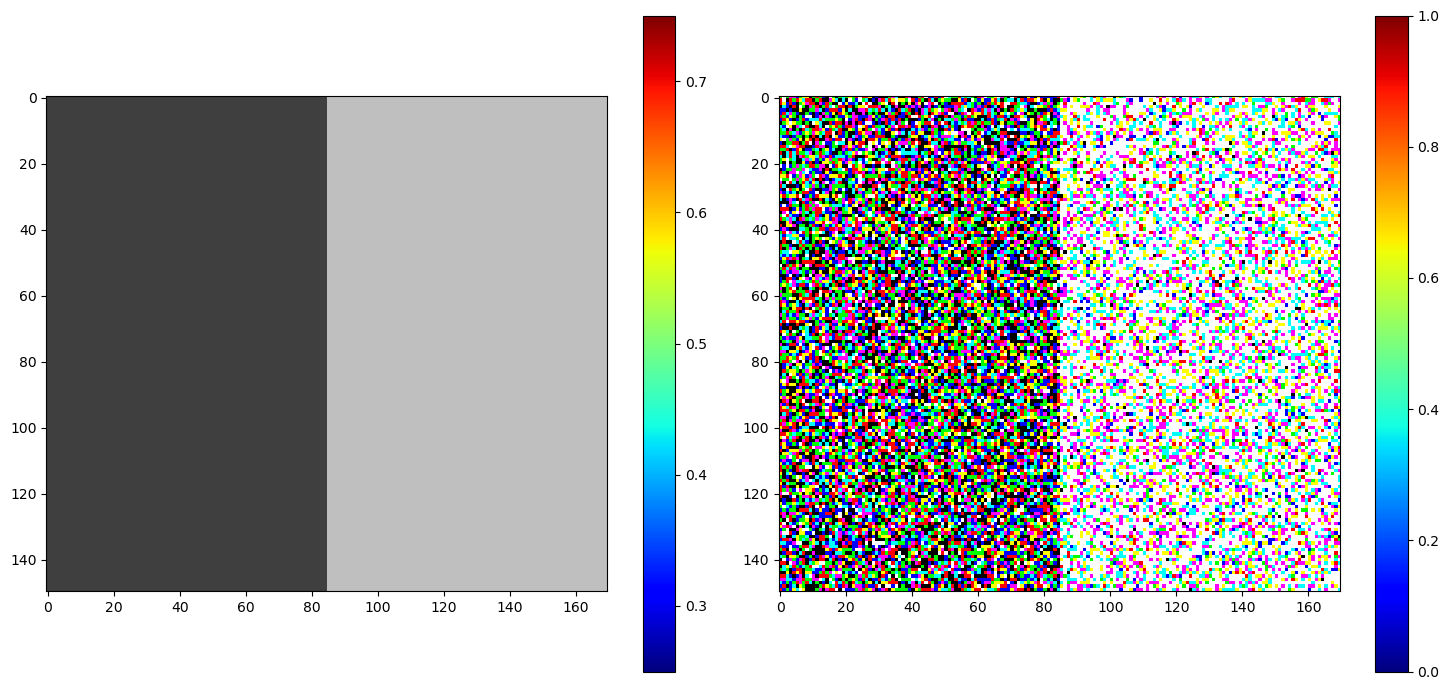

In [46]:
# build 2D gaussian distribution
# x = np.linspace(-5, 5, simulated_tex.shape[1])
# y = np.linspace(-5, 5, simulated_tex.shape[0])
# X, Y = np.meshgrid(x, y)
# Z = np.exp(-0.05 * (X**2 + Y**2))
# Z = Z / Z.sum()
# # norm between 0 and 1
# Z = (Z - Z.min()) / (Z.max() - Z.min())

Z = np.zeros_like(simulated_tex)

Z[:, :Z.shape[1]//2] = 0.25
Z[:, Z.shape[1]//2:] = 0.75

simulation_tex = np.zeros_like(simulated_tex)

r_mask = np.random.random(simulated_tex.shape)
mask = r_mask < (0.1 * (1 - Z))
simulation_tex[mask] = 1

mask = r_mask > (0.9 * (1 - Z))
simulation_tex[mask] = 2

# show the 2D gaussian distribution
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
im0 = axs[0].imshow(Z, cmap='jet')
fig.colorbar(im0, ax=axs[0], orientation='vertical')
im1 = axs[1].imshow(simulation_tex, cmap='jet')
fig.colorbar(im1, ax=axs[1], orientation='vertical')
plt.tight_layout()
plt.show()


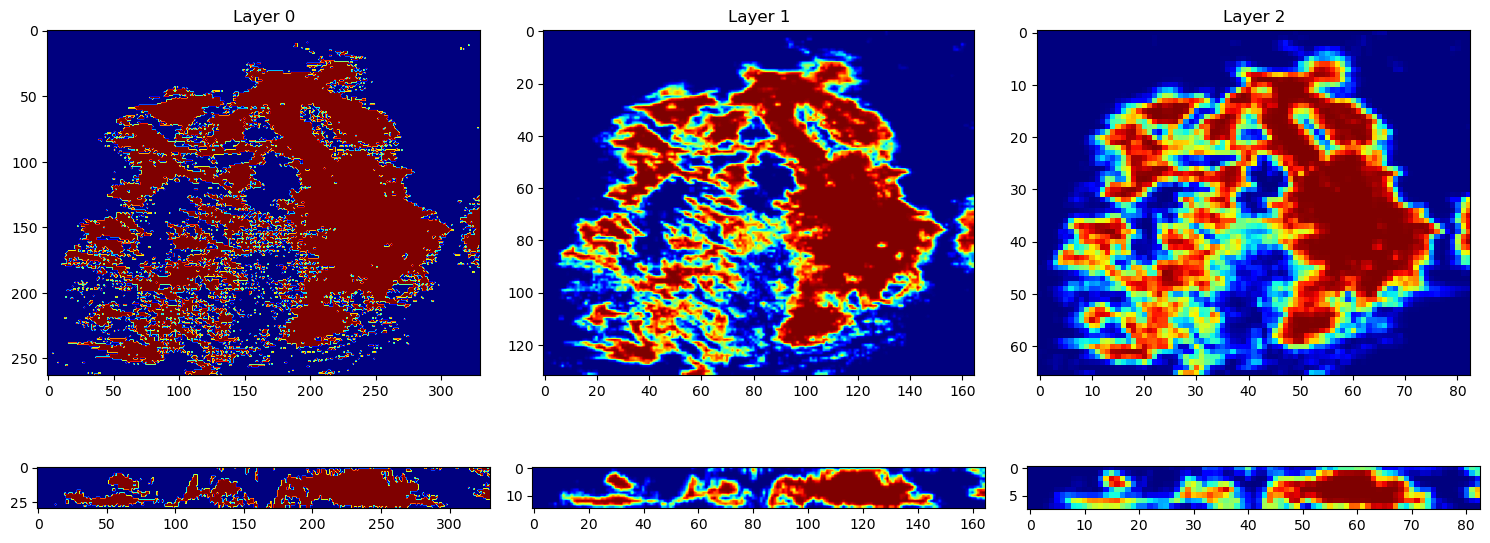

In [55]:

import numpy as np
from skimage.transform import pyramid_gaussian

img = slab[:, :, slab.shape[2]//2]
pyramid = tuple(pyramid_gaussian(slab, max_layer=2, downscale=2,
                                 preserve_range=True))

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 6.8))

for i, p in enumerate(pyramid):
    axs[0, i].imshow(p[:, :, p.shape[2]//2], cmap="jet_r")
    axs[0, i].set_title(f"Layer {i}")

    axs[1, i].imshow(p[p.shape[0]//2, :, :].T , cmap="jet_r")
    axs[1, i].sharex(axs[1, i])
plt.tight_layout()
plt.show()

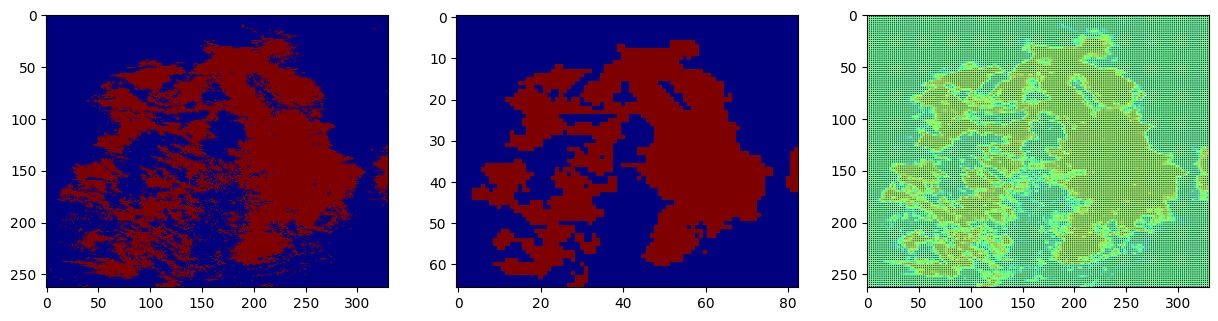

In [131]:
sim_slab = np.zeros_like(slab)
# set pyramid[1] into sim_slab with step 2
sim_slab[::2, ::2, ::2] = pyramid[1]


fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].imshow(slab[:, :, slab.shape[2]//2], cmap="jet_r")
axs[1].imshow(pyramid[2][:, :, pyramid[2].shape[2]//2] > 0, cmap="jet_r")
axs[2].imshow(sim_slab[:, :, 16], cmap="jet_r", vmin=-1, vmax=1)
plt.show()

In [75]:
import numpy as np
from scipy import fft as spfft


def slab_fft(slab):
    fft_shape = [spfft.next_fast_len(s, True) for s in slab.shape]
    fft_slab = spfft.rfftn(slab, fft_shape, workers=None)
    return fft_slab, fft_shape

def template_corr(fft_slab, fft_shape, template):
    fft_template = spfft.rfftn(template, fft_shape).conj()
    corr = spfft.irfftn(fft_slab * fft_template, fft_shape, workers=None).real
    return corr


slab_ = pyramid[1]
# template_ = slab_[]
template_ = np.random.random((10, 10, 10)).astype(np.float32)


%timeit slab_fft(slab_)
fft_slab, fft_shape = slab_fft(slab_)
%timeit template_corr(fft_slab, fft_shape, template_)

1.2 ms ± 35.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.97 ms ± 76.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
import tensorflow as tf

def slab_tf_fft(slab):
    fft_shape = [spfft.next_fast_len(s, True) for s in slab.shape]
    fft_slab = tf.signal.rfft3d(slab, fft_shape)
    return fft_slab, fft_shape


def template_tf_corr(fft_slab, fft_shape, template):
    fft_template = tf.math.conj(tf.signal.rfft3d(template, fft_shape))
    corr = tf.math.real(tf.signal.irfft3d(fft_slab * fft_template, fft_shape))
    return corr


slab_tf = tf.convert_to_tensor(slab_, dtype=tf.float32)
template_tf = tf.convert_to_tensor(template_, dtype=tf.float32)


%timeit slab_tf_fft(slab_tf)
fft_slab, fft_shape = slab_tf_fft(slab_tf)
%timeit template_tf_corr(fft_slab, fft_shape, template_tf)

716 μs ± 13.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.87 ms ± 24.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [77]:
1.87 * 0.001 * (slab_.shape[0] * slab_.shape[1] * slab_.shape[2]) / 3600

0.16970250000000003

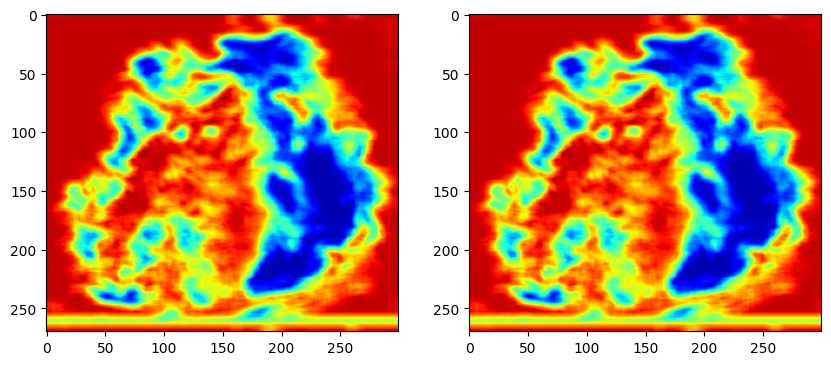

In [39]:
sp_corr = template_corr(fft_slab, fft_shape, template_)
tf_corr = template_tf_corr(fft_slab, fft_shape, template_tf)

fig, axs = plt.subplots(ncols=2, figsize=(10, 10))
axs[0].imshow(sp_corr[:, :, 5], cmap="jet")
axs[1].imshow(tf_corr[:, :, 5], cmap="jet")
plt.show()

In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [2]:
import tensorflow as tf
import time

# Create a random 3D image tensor
image = tf.random.normal([248, 512, 32], dtype=tf.float32)

# Warm-up run to ensure accurate timing
_ = tf.signal.rfft3d(image)

# Measure execution time
start_time = time.perf_counter()
image_fft = tf.signal.rfft3d(image)
end_time = time.perf_counter()

print(f"Execution time: {end_time - start_time:.6f} seconds")

Execution time: 0.004945 seconds


2025-02-25 15:31:32.855652: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-25 15:31:32.855736: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-25 15:31:32.855748: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1740493892.856097  240058 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1740493892.856306  240058 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
248 * 512 * 32

4063232

In [3]:
from tqdm import tqdm
import numpy as np

template_ = np.zeros((5, 5, 5), dtype=np.float32)

image = tf.convert_to_tensor(image, dtype=tf.float32)
template_ = tf.convert_to_tensor(template_, dtype=tf.float32)

for _ in tqdm(range(image.shape[0] * image.shape[1] * image.shape[2])):
    _ = tf.signal.rfft3d(template_, fft_length=image.shape)

  0%|          | 837/4063232 [00:05<7:59:47, 141.11it/s]


KeyboardInterrupt: 

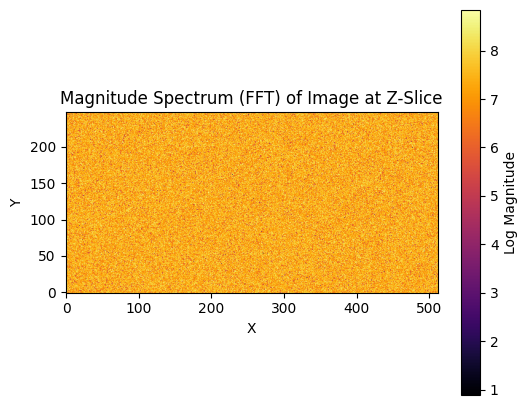

In [5]:
import numpy as np
import matplotlib.pyplot as plt

image_fft_np = np.abs(image_fft.numpy())  # Magnitude
image_fft_log = np.log1p(image_fft_np)  # Log scale for visibility

# Select a central slice along the Z-axis for visualization
z_center = image_fft_log.shape[2] // 2
fft_slice = image_fft_log[:, :, z_center]

# Plot the magnitude spectrum
plt.figure(figsize=(6, 5))
plt.imshow(fft_slice, cmap='inferno', origin='lower')
plt.colorbar(label='Log Magnitude')
plt.title('Magnitude Spectrum (FFT) of Image at Z-Slice')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [11]:
0.014 * 5112720 / 3600

19.8828

In [30]:
import bitis as bt


simulation_tex = np.zeros(slab.shape, dtype=np.float32)
simulation = bt.AdaptiveSampling(simulation_tex,
                                 slab,
                                 max_known_pixels=30,
                                 max_template_size=100,
                                 min_template_size=5)

simulated_tex = simulation.run()

  0%|          | 795/5112720 [00:42<75:49:51, 18.73it/s]


KeyboardInterrupt: 

In [1]:
import numpy as np

x = np.zeros((100, 100, 100), dtype=np.float32)
w = np.zeros(np.array(x.shape) - 1, dtype=np.float32)

%timeit x[:-1, :-1, :-1] * w

427 μs ± 14.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
import numba as nb
import numpy as np
import tensorflow as tf
from tqdm import tqdm


@nb.jit(nopython=True, parallel=False)
def laplace(u_new, u, w):
    n_i = u.shape[0]
    n_j = u.shape[1]
    for ii in nb.prange(n_i * n_j):
        i = int(ii / n_j)
        j = ii % n_j

        if i == 0 or j == 0 or i == n_i - 1 or j == n_j - 1:
            continue

        u_new[i, j] = (u[i-1, j] * w[i, j, 0] +
                       u[i, j-1] * w[i, j, 1] +
                       u[i, j] * w[i, j, 2] +
                       u[i, j+1] * w[i, j, 3] +
                       u[i+1, j] * w[i, j, 4])

    return u_new


def laplace_np(u_new, u, w):
    u_new[1:-1, 1:-1] = (u[:-2, 1:-1] * w[1:-1, 1:-1, 0] +
                         u[1:-1, :-2] * w[1:-1, 1:-1, 1] +
                         u[1:-1, 1:-1] * w[1:-1, 1:-1, 2] +
                         u[1:-1, 2:] * w[1:-1, 1:-1, 3] +
                         u[2:, 1:-1] * w[1:-1, 1:-1, 4])

    return u_new


def sum_section_tf(u_new, u, w):
    u_new = tf.reduce_sum(u * w, axis=-1)
    return u_new
    
    



x = np.random.random((400, 400)).astype(np.float32)
w = np.random.random((400, 400, 5)).astype(np.float32)
x_new = np.zeros_like(x)

%timeit laplace_np(x_new, x, w)
%timeit laplace(x_new, x, w)
u = tf.convert_to_tensor(x, dtype=tf.float32)
w = tf.convert_to_tensor(w, dtype=tf.float32)
    
u_new = tf.Variable(tf.zeros_like(u))
%timeit laplace_tf(x_new, x, w)


578 μs ± 10.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
694 μs ± 7.49 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.84 ms ± 4.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
